<a href="https://colab.research.google.com/github/AmiraliEsi83/The-CIFAR-10-dataset/blob/main/Cifar10_Resnet_50_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
my_image = X_train[12]

In [ ]:
len(X_train), len(y_train),len(X_test), len(y_test)

(50000, 50000, 10000, 10000)

In [ ]:
X_train = X_train.astype('float32') / 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_test = X_test.astype('float32') / 255
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
input = tf.keras.Input(shape=(32,32,3))
temp_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_tensor=input)
gap = tf.keras.layers.GlobalMaxPooling2D()(temp_model.output)
output = tf.keras.layers.Dense(10, activation="softmax")(gap)

model = tf.keras.Model(temp_model.input, output)

In [ ]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = tf.keras.metrics.CategoricalAccuracy(),
    optimizer= tf.keras.optimizers.Adam()
)

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs = 100, verbose=2)

391/391 - 65s - loss: 1.3263 - categorical_accuracy: 0.5873 - 65s/epoch - 166ms/step


In [ ]:
evaluation = model.evaluate(X_test,y_test)
print(f"Test accuracy: {evaluation[1]*100:.2f}%")

313/313 [==============================] - 7s 14ms/step - loss: 5.4473 - categorical_accuracy: 0.1000
Test accuracy: 10.00%


In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

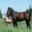

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.fromarray(X_train[12], 'RGB')
img.save('my.png')
img.show()

In [ ]:
image = cv2.imread('my.png')
image = cv2.resize(image,(32,32))
image = image.astype('float32') / 255
image = np.expand_dims(image,axis=0)

In [ ]:
predictions = model.predict(image)
i = np.argmax(predictions[0])

1/1 [==============================] - 0s 36ms/step


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

In [ ]:
icam = GradCAM(model,i,  'conv5_block3_3_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap,(32,32))

image = cv2.imread('my.png')
image = cv2.resize(image,(32,32))
print(heatmap.shape,image.shape)

(32, 32) (32, 32, 3)


In [ ]:
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

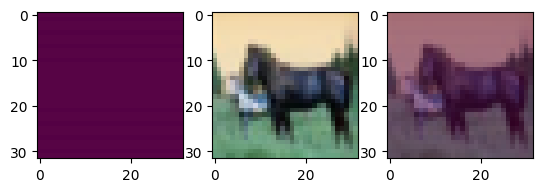

In [ ]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)